<a href="https://colab.research.google.com/github/OMIDUFMG2019/Algorithmic-trading/blob/master/randomHFCM_without_bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install -U git+https://github.com/PYFTS/pyFTS

  Cloning https://github.com/PYFTS/pyFTS to /tmp/pip-req-build-bbmvr1yr
  Running command git clone -q https://github.com/PYFTS/pyFTS /tmp/pip-req-build-bbmvr1yr
  Created wheel for pyFTS: filename=pyFTS-1.6-cp36-none-any.whl size=207416 sha256=07d0b0e65db42baf637998226fbe7e689ab0e773be814e4548336a40d3869e12
  Stored in directory: /tmp/pip-ephem-wheel-cache-qxkis7ps/wheels/e7/32/a9/230470113df5a73242a5a6d05671cb646db97abf14bbce2644
Successfully built pyFTS


In [2]:
from pyFTS.fcm import Activations
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import numpy as np
from math import e,sqrt
from math import e,sqrt,sin,cos
def step(x, deriv=False):
    if deriv:
        return np.abs(1 * (x == 0))
    else:
        return np.abs(1 * (x > 0))


def sigmoid(x, deriv=False):
    if deriv:
        #return sigmoid(x)*(1 - sigmoid(x))
        return x * (1 - x)
    else:
        return 1 / (1 + np.exp(-x))


def softmax(x, deriv=False):
    if deriv:
        pass
    else:
        mvs = sum([np.exp(k) for k in x.flatten()])
        return np.array([np.exp(k)/mvs for k in x.flatten()])


def tanh(x, deriv=False):
    if deriv:
        return 1 - np.tanh(x)**2
    else:
        return np.tanh(x)


def relu(x, deriv=False):
    if deriv:
        return np.abs(1. * (x > 0))
    else:
        return np.abs(x * (x > 0))


#leaky Relu
def leaky(x,deriv=False):
   if deriv:
       return 0.01 if (x < 0).any() else np.abs(1.*(x>0))
   else:
       return (0.01)*x if (x < 0).any() else np.abs(x*(x>0))


# Randomized leaky rectified linear unit (RReLU):
def rrelu(x,a=0.01,deriv=False):
  if deriv:
    return a if x < 0 else np.abs(1.*(x>0))
  else:
    return a*x if x < 0 else np.abs(x * (x > 0))
  

# SoftPlus
def softplus(x,deriv=False):
  if deriv:
    return 1/(1+((e)**-x))
  else:
    return np.log(1+((e)**x))

#softminus
def softminus(x,deriv=False):
  if deriv:
    return 1-1/(1+((e)**-x))
  else:
    return x-np.log(1+((e)**x))

# Softsign function:
def softsign(x,deriv=False):
  
  if deriv:
    return 1/((1+np.abs(x)))**2
  else:
    return x/(1+np.abs(x))
  
# SoftExponential:
def softex(x,a=0.05,deriv=False):
  if deriv:
    return 1/(1-a*(a+x)) if a < 0 else (e)**(a*x)
  else:
    if a < 0:
      return -((np.log(1-a*(x+a)))/a)
    elif a == 0:
      return x
    elif a > 0:
      return (((e)**(a*x))/a)+a


# Gaussian: 
def gaussian(x,deriv=False):
  if deriv:
    return -2*x*(e)**((-x)**2)
  else:
    return (e)**((-x)**2)

# Inverse square root LINEAR unit (ISRLU):
def isrlu(x,a=0.01,deriv=False):
   if deriv:
     return (1/sqrt(1+(a*(x**2))))**3 if (x < 0).any() else np.abs(1)
   else:
    return (x/sqrt(1+(a*(x**2)))) if (x < 0).any() else x

#safe_sigmoid
def safesigmoid(x,deriv=False):
  if deriv:
    return 0.5 * (1.0 - np.tanh(0.5 * x)**2)
  else:
    return 0.25 * (1 + np.tanh(0.5 * x))


 # Soft Clipping:
def softclip(x,a=0.01,p=1,deriv=False):
  if deriv:
    def sech(x):
      return np.cosh(x)**(-1)
    return (0.5)*(np.sinh(p/2))*(sech((p*x)/2))*sech((p/2)*(1-x))
  else:
    return (1/a)*(np.log10((1+((e)**(a*x)))/(1+(e)**(a*(x-1)))))  

        

In [188]:
class FuzzyCognitiveMap(object):
    def __init__(self, **kwargs):
        super(FuzzyCognitiveMap, self).__init__()
        self.order = kwargs.get('order',1)
        self.concepts = kwargs.get('partitioner',None)
        self.weights = [] 
        self.activation_function = softex

    def activate(self, memberships):
        dot_products = np.zeros(len(self.concepts))
        for k in np.arange(0, self.order):
            dot_products += np.dot(np.array(memberships[k]).T, self.weights[k])
        return self.activation_function( dot_products )


In [190]:

from pyFTS.models import hofts

def func(values, b0, b1, b2,b3,b4,b5):
    z1,z2,z3,z4,z5= values
    return b0 + (b1 * z1) + (b2 * z2)+(b3 * z3)+(b4* z4)+(b5 * z5)

#def func(values, a, b, c,d,e,f,g,h,i,j,k):
    #z1,z2,z3,z4,z5,z6,z7,z8,z9,z10= values
    #return a + (b * z1) + (c * z2)+(d * z3)+(e * z4)+(f * z5)+(g * z6)+(h * z7)+(i * z8)+(j * z9)+(k * z10)


def func2(x, y, a, b, c):
    z1,z2 = x
    return y - a + (b * z1) + (c * z2)


class FCM_FTS(hofts.HighOrderFTS):

    def __init__(self, **kwargs):
        super(FCM_FTS, self).__init__(**kwargs)

        num_concepts = self.partitioner.partitions

        # FCM1 Initialization
        
        self.fcm1 = FuzzyCognitiveMap(**kwargs)

        self.fcm1.weights = (np.random.rand(self.order, num_concepts, num_concepts) * 2) - 1
        
        # FCM2 Initialization

        self.fcm2 = FuzzyCognitiveMap(**kwargs)

        self.fcm2.weights = (np.random.rand(self.order, num_concepts, num_concepts) * 2) - 1

        # FCM3 Initialization

        self.fcm3 = FuzzyCognitiveMap(**kwargs)

        self.fcm3.weights = (np.random.rand(self.order, num_concepts, num_concepts) * 2) - 1

        # FCM4 Initialization

        self.fcm4 = FuzzyCognitiveMap(**kwargs)

        self.fcm4.weights = (np.random.rand(self.order, num_concepts, num_concepts) * 2) - 1

        # FCM5 Initialization

        self.fcm5 = FuzzyCognitiveMap(**kwargs)

        self.fcm5.weights = (np.random.rand(self.order, num_concepts, num_concepts) * 2) - 1


        # FCM6 Initialization

        #self.fcm6 = FuzzyCognitiveMap(**kwargs)

        #self.fcm6.weights = (np.random.rand(self.order, num_concepts, num_concepts) * 2) - 1

        # FCM7 Initialization

        #self.fcm7 = FuzzyCognitiveMap(**kwargs)

        #self.fcm7.weights = (np.random.rand(self.order, num_concepts, num_concepts) * 2) - 1

        # FCM8 Initialization

        #self.fcm8 = FuzzyCognitiveMap(**kwargs)

        #self.fcm8.weights = (np.random.rand(self.order, num_concepts, num_concepts) * 2) - 1

        # FCM9 Initialization

        #self.fcm9 = FuzzyCognitiveMap(**kwargs)

        #self.fcm9.weights = (np.random.rand(self.order, num_concepts, num_concepts) * 2) - 1

        # FCM10 Initialization

        #self.fcm10 = FuzzyCognitiveMap(**kwargs)

        #self.fcm10.weights = (np.random.rand(self.order, num_concepts, num_concepts) * 2) - 1

       

        # Coefficients

        self.theta = np.zeros(6)
        
    def forecast(self, data, **kwargs):
        y1 = []

        midpoints = np.array([fset.centroid for fset in self.partitioner])

        for t in np.arange(self.order, len(data)+1):

            sample = data[t - self.order : t]

            fuzzyfied = self.partitioner.fuzzyfy(sample, mode='vector')

            # Evaluate FCM 1

            activation1 = self.fcm1.activate(fuzzyfied)

            fcm1_forecast = np.dot(midpoints, activation1)/np.nanmax([1, np.sum(activation1)])

            # Evaluate FCM 2

            activation2 = self.fcm2.activate(fuzzyfied)

            fcm2_forecast = np.dot(midpoints, activation2)/np.nanmax([1, np.sum(activation2)])

             # Evaluate FCM 3

            activation3 = self.fcm3.activate(fuzzyfied)

            fcm3_forecast = np.dot(midpoints, activation3)/np.nanmax([1, np.sum(activation3)])

             # Evaluate FCM 4

            activation4 = self.fcm4.activate(fuzzyfied)

            fcm4_forecast = np.dot(midpoints, activation4)/np.nanmax([1, np.sum(activation4)])

             # Evaluate FCM 5

            activation5 = self.fcm5.activate(fuzzyfied)

            fcm5_forecast = np.dot(midpoints, activation5)/np.nanmax([1, np.sum(activation5)])

             # Evaluate FCM 6

            #activation6 = self.fcm6.activate(fuzzyfied)

            #fcm6_forecast = np.dot(midpoints, activation6)/np.nanmax([1, np.sum(activation6)])

             # Evaluate FCM 7

            #activation7 = self.fcm7.activate(fuzzyfied)

            #fcm7_forecast = np.dot(midpoints, activation7)/np.nanmax([1, np.sum(activation7)])

             # Evaluate FCM 8

           # activation8 = self.fcm8.activate(fuzzyfied)

            #fcm8_forecast = np.dot(midpoints, activation8)/np.nanmax([1, np.sum(activation8)])

             # Evaluate FCM 9

            #activation9 = self.fcm9.activate(fuzzyfied)

            #fcm9_forecast = np.dot(midpoints, activation9)/np.nanmax([1, np.sum(activation9)])

             # Evaluate FCM 10

            #activation10 = self.fcm10.activate(fuzzyfied)

            #fcm10_forecast = np.dot(midpoints, activation10)/np.nanmax([1, np.sum(activation10)])

           
            # Combine the results

            result = func((fcm1_forecast, fcm2_forecast,fcm3_forecast,fcm4_forecast,fcm5_forecast), *self.theta)

            if str(result) == 'nan' or result == np.nan or result == np.Inf:
                print('error')

            y1.append(result)

        return y1

    def run_fcm(self, fcm, data):
        ret = []
        midpoints = np.array([fset.centroid for fset in self.partitioner])
        for t in np.arange(self.order, len(data)+1):
            sample = data[t - self.order : t]
            fuzzyfied = self.partitioner.fuzzyfy(sample, mode='vector')
            activation = fcm.activate(fuzzyfied)
            final = np.dot(midpoints, activation)/np.nanmax([1, np.sum(activation)])
            ret.append(final)
        return ret

    def train(self, data, **kwargs):
        from scipy.optimize import curve_fit, least_squares
        
        output1 = model.run_fcm(model.fcm1, data)

        output2 = model.run_fcm(model.fcm2, data)

        output3 = model.run_fcm(model.fcm3, data)

        output4 = model.run_fcm(model.fcm4, data)

        output5 = model.run_fcm(model.fcm5, data)

        #output6 = model.run_fcm(model.fcm6, data)

        #output7 = model.run_fcm(model.fcm7, data)

        #output8 = model.run_fcm(model.fcm8, data)

        #output9 = model.run_fcm(model.fcm9, data)
        
        #output10 = model.run_fcm(model.fcm10, data)


        self.theta, _ = curve_fit (func, (output1[:-1], output2[:-1],output3[:-1],output4[:-1],output5[:-1]), data[self.order:] )

        #f = lambda x, a, b, c: func2(x, data[self.order:], a, b, c)

        #self.theta, _ = least_squares (f, (output1[:-1], output1[:-1]) )

        print(self.theta)


[ 4.09803320e+04 -3.17535973e+01 -1.44792705e+00 -3.73333422e+01
 -1.44244879e+01  1.43423916e+01]


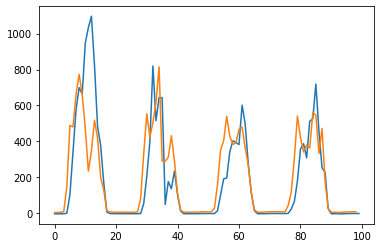

In [219]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyFTS.fcm import fts as fcm_fts
from pyFTS.partitioners import Grid
from pyFTS.common import Util
from pyFTS.common import Membership as mf
from scipy.optimize import least_squares
from scipy.optimize import leastsq
import pandas as pd

df = pd.read_csv('https://query.data.world/s/56i2vkijbvxhtv5gagn7ggk3zw3ksi', sep=';')
data = df['glo_avg'].values[:8000]
partitioner = Grid.GridPartitioner(data=data, npart=10,mf=mf.trimf)
y= data

model = FCM_FTS(partitioner=partitioner, order=2)

model.fit(y)
import matplotlib.pyplot as plt

plt.plot(y[100:200])
plt.plot(model.forecast(y[100:200]))

In [220]:
from pyFTS.benchmarks import Measures
forecasts=model.forecast(y)
rmse = Measures.rmse(y[model.max_lag:], forecasts[:-1])
print(rmse)

170.30823003405388
